In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import dicom 
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
# INPUT_FOLDER = '../input/sample_images/'
# patients = os.listdir(INPUT_FOLDER)
# patients.sort()

In [2]:
def load_scan(path):
    slices = [dicom.read_file(path)]
#     for s in os.listdir(path):
#         if s.endswith(".dcm"):
# #             print (s)
#             slices.append(dicom.read_file(path + '/' + s, force=True))
    # File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. 
    # Use force=True to force reading.
#     slices.sort(key = lambda x: int(x.InstanceNumber))
#     try:
#         slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
#     except:
#         slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
#     for s in slices:
#         s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [3]:
# '/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000030.dcm'

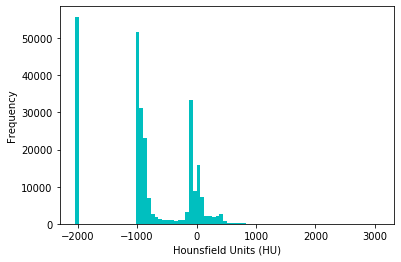

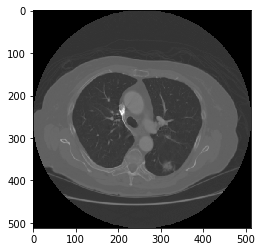

In [4]:
first_patient = load_scan('/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000030.dcm')
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[0], cmap=plt.cm.gray)
plt.show()

In [5]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
#     spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    # not 3d
    spacing = spacing[1:]
#     print(spacing[1:])

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [6]:
pix_resampled, spacing = resample(first_patient_pixels[0], first_patient, [1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (1, 512, 512)
Shape after resampling	 (360, 360)


In [7]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
#     background_label = labels[0,0,0]
    background_label = labels[0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
#     l_max = largest_label_volume(labels, bg=0)
#     if l_max is not None: # There are air pockets
#         binary_image[labels != l_max] = 0
 
    return binary_image

In [8]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
# segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
segmented_lungs

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [9]:
import matplotlib.patches as patches
import cv2
# normalized = normalize(pix_resampled)
# # [[302.0, 351.0, 329.0, 384.0]]",891.0
# # xmin ymin xmax ymax
# # pix_resampled.shape # 360,360
ymin, ymax = (351.0 * 360.0) / 512.0, (384.0 * 360.0) / 512.0 #ymin ymax        
xmin, xmax = (302.0 * 360.0) / 512.0, (329.0* 360.0) / 512.0 #xmin, xmax

# ymin, ymax = (351.0 * 0.7), (384.0 * 0.7) #ymin ymax        
# xmin, xmax = (302.0 * 0.7), (329.0 * 0.7) #xmin, xmax

# fig,ax = plt.subplots(1, figsize=(5,5))
# ax.imshow(normalized, cmap=plt.cm.gray)
# rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
# ax.add_patch(rect)
# plt.show()

# plt.imshow(normalized, cmap=plt.cm.gray)
# rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
# plt.add
# plt.show()

In [10]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

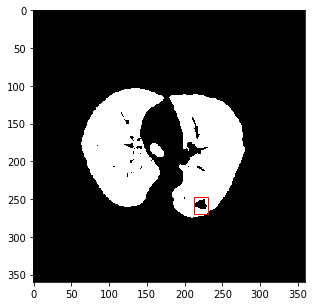

In [11]:
normalized = normalize(segmented_lungs)


fig,ax = plt.subplots(1, figsize=(5,5))
ax.imshow(normalized, cmap=plt.cm.gray)
rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

# plt.imshow(normalized, cmap=plt.cm.gray)
# plt.show()

In [12]:
PIXEL_MEAN = 0.32

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [13]:
# minA = []
# maxA = []

average = []
df = pd.read_csv("../large_nodules.csv")
for index, row in df.iterrows():
#     new_path = (row.path).replace(row.imageName, "/"+row.imageName)
#     print(new_path)
    scan = load_scan(row.path)
    scan_pixels = get_pixels_hu(scan)
    pix_resampled, spacing = resample(scan_pixels[0], scan, [1,1])
    segmented_lungs = segment_lung_mask(pix_resampled, False)
    normal = normalize(segmented_lungs)
    final = zero_center(normal)
    avg = np.mean(final, axis=(0, 1))
    average.append(avg)
#     fig,ax = plt.subplots(1, figsize=(5,5))
#     ax.imshow(final, cmap=plt.cm.gray)
#     plt.show()
#     minA.append(np.min(pix_resampled))
#     maxA.append(np.max(pix_resampled))
    
print("average: ", (sum(average)/len(average)))

average:  0.3944852940712288


In [14]:
# print("min :", min(minA), " max: ", max(maxA)," average: ", (sum(average)/len(average)))

NameError: name 'minA' is not defined